## Notebook for Lesson 1 - Review of Neural Net Basics

**Note:** lesson notebooks are created for the purpose of in-class illustrations and student experimentation after class.

Back to [week 1 slides](https://docs.google.com/presentation/d/1xHljj6EVfxc9KG0UD2G0-72dUbhif3oDCRENA-lv22Q/edit#slide=id.g1267b8de356_1_182)

**Description:** Review some basics about cross entropy loss functions, vectors, matrices and tensors that we will use throughout the rest of the class.<br>

Section 1 deals with setup and prerequisites, which does not need a lot of discussion.
Cross entropy and loss functions are handled in section 2. Section 3 looks at vectors, matrices and their implementation and manipulation in Tensorflow. Section 4 discusses and demonstrates the softmax operation.  Section 5 uses the keras sequential API.  Section 6 introduces the Keras functional API, which we'll use in the remainder of the class, and demonstrates the effect of normalization on a layer's output.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Entropy and Loss Function Review](#entropyReview)
    * 2.1 [Entropy](#entropyReview)  
    * 2.2 [Cross Entropy](#crossEntropy)
    * 2.3 [KL Divergence](#klDivergence)
    * 2.4 [Checking a Few Things About Cross-Entropy](#checkingXEntropy)    
  * 3. [A Few Basic Words on Vector and Matrix Calculations](#vectorMatrixCalc)
    * 3.1 [Tensors and Tensor Manipulation](#tensorManipulation)
  * 4. [Familiarization with the Output Layer and the Softmax Operation](#softmax)
  * 5. [Most Basic Keras Intro](#basicKeras)
  * 6. [Effects of Layer Normalization](#normalization)




[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-summer-main/blob/master/materials/lesson_notebooks/lesson_1_NN_Review.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>

## 1. Setup

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from random import random
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [2]:
# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, history2):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - no dropout')
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(0, 0.7)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - no dropout')
    ax3.plot(history1.history['categorical_accuracy'])
    ax3.plot(history1.history['val_categorical_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(0.7, 1.0)


    ax2 = axs[0, 1]
    ax2.set_title('loss - with dropout')
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(0, 0.7)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - with dropout')
    ax4.plot(history2.history['categorical_accuracy'])
    ax4.plot(history2.history['val_categorical_accuracy'])
    ax4.set_ylim(0.7, 1.0)

[Return to Top](#returnToTop)  
<a id = 'entropyReview'></a>

## 2. Entropy and Loss Review


### 2.1 Entropy

[Entropy (Shannon entropy)](https://en.wikipedia.org/wiki/Shannon_entropy) is a notion of how "uncertain" the outcome of some experiment is.  The more uncertain - or the more spread out the distribution - the higher the entropy. *(Aside: some of you may have encountered "entropy" in a thermodynamics class.  Entropy as we're defining it here is conceptually similar - a notion of the amount of disorder in a system, and the concepts are closely related.)*

Mathematically, for a (discrete) random variable $X$,

$$\text{Entropy}(X) = H(X) = -\Sigma_x\ p(x) \log_2 p(x)$$

*(We take $0 \times log_2(0) = 0$, although in the "real world" probabilities are rarely equal to 0.)*

Or, in English: imagine you have some probability distribution over a discrete set of events $X$.  Loop over each event and take the product of the probability of that event and the base-2 log of the probability.  Or, put another way, find the expected value $E[-\log_2 p(x)]$ for this probability distribution.



Imagine a probability distribution $p$ across 5 outcomes.  These would correspond to the true distribution over five labels in a multi-class classification problem.

In [3]:
p = np.array([0.3,0.2,0.1,0.25,0.15])
print(p)

[0.3  0.2  0.1  0.25 0.15]


Calculate the entropy:

In [4]:
S = -(0.3 * np.log2(0.3) + 0.2 * np.log2(0.2) + 0.1 * np.log2(0.1) + 0.25 * np.log2(0.25) + 0.15 * np.log2(0.15))
print(S)

2.228212945841001


Explicit, but tedious and silly. Better way? Use vectors:

In [5]:
S = - np.dot(p, np.log2(p))
print(S)

2.228212945841001


Same result. Good.

[Return to Top](#returnToTop)  
<a id = 'crossEntropy'></a>

### 2.2 Cross Entropy

What if we get the code wrong? Suppose we have a finite sample of messages (introducing some _variance_), and we train a machine learning model (introducing some _bias_) to estimate the true probabilities. Let's call the predicted distribution $Q(X)$.

Now we generate a code based on $Q(X)$, and use it to encode real messages (which come from $P(X)$). How many bits do we use, on average?

If we design an optimal code for $Q$, we use $-\log_2 Q(x)$ bits for message $x$. Then we average this over $x \sim P$ to get:

$$ \text{CE}(P,Q) = \sum_{x} - P(x) \log_2 Q(x) = \mathrm{E}_{x \sim P(x)}\left[ -\log_2 Q(x) \right] $$

Since we "crossed" the code from $Q$ and used it on $P$, this is known as the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy). Note that $ \text{CE}(P,Q) \ge H(P) $, because we know that the code trained on $Q$ can't possibly be better than the optimal code on $P$ itself!

In the form above, this is the most commonly used loss function in machine learning. In unsupervised learning (density estimation), we use it exactly as-is, with $x$ as the data. In supervised learning, we take the random variable to be the label $y$, and take our distributions to be conditional ones: $P(y\ |\ x)$ and $Q(y\ |\ x)$:
$$ \text{CE}(P,Q)(x) = \sum_{y'} -P(y'\ |\ x) \log_2 Q(y'\ |\ x) $$
It's common to average over $x$ and to approximate $P(y\ |\ x)$ with discrete samples $(x,y)$ from a test set $T$, in which case we get:

$$ \text{CE}(P,Q)
\approx \frac{1}{|T|} \sum_{(x,y) \in T} \sum_{y'} -\mathbb{1}[y = y'] \log_2 Q(y'\ |\ x)
= \frac{1}{|T|} \sum_{(x,y) \in T} -\log_2 Q(y\ |\ x)
$$

We'll commonly also write this using natural logarithms, but you can always convert between the two by the formula $ \log_2(x) = \log_2(e) \cdot \ln(x) $.

[Return to Top](#returnToTop)  
<a id = 'klDivergence'></a>

### 2.3 KL Divergence

We learned that we use the word "cross-entropy" to refer to the average number of bits we need if we design our code with $Q(X)$ (i.e. our model) in mind but end up sending with probability $P(X)$ (i.e. the test set).  Similarly, "entropy" is the average bits we need if we design with the right distribution in mind.

We don't yet have a name for the difference between these quantities (i.e. the size of the *penalty* for using the wrong distribution to optimize our code).  That difference is known as the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), or KL divergence for short.

It is a measure of how different two probability distributions are.  The more $Q$ differs from $P$, the worse the penalty would be, and thus the higher the KL divergence.

That is,
$$ D_{KL}(P\ ||\ Q) = CE(P, Q) - H(P)$$

From a machine learning perspective, the KL divergence measures the "avoidable" error - when our model is perfect (i.e. the *distribution* $\hat{P}(y\ |\ x_i) = P(y\ |\ x_i)$, the KL divergence goes to zero. In general, the cross-entropy loss - and prediction accuracy - will not be zero, but will be equal to the entropy $H(P)$. This "unavoidable" error is the [Bayes error rate](https://en.wikipedia.org/wiki/Bayes_error_rate) for the underlying task.

**Important note:** we're taking the true distribution $y_i = P(y\ |\ x_i) = [1, 0, 0, 0]$ in this example to be one-hot (i.e. all mass on one value). This is different from the one-hot encoding we use for training labels, which are _observations_ (single values) _sampled_ from some true distribution $y_i^\text{obs} \sim P(y\ |\ x_i)$. In that case, one-hot encoding is just a convenient shortcut. In general - and particularly in NLP - we'll have some label uncertainty, and the true distribution $P(y\ |\ x_i)$ will be spread among potentially many possibilities.

One final observation:  cross-entropy is not symmetric (think about how $P$ and $Q$ appear in the formula to understand why).  As a result KL Divergence isn't symmetric either (if you want to prove this to yourself substitute in for CE and E in the equation above and simplify).  So while KL divergence is a measure of similarity, it's useful to keep in mind that $D_{KL}(P\ ||\ Q) \ne D_{KL}(Q\ ||\ P)$.

[Return to Top](#returnToTop)  
<a id = 'checkXEntropy'></a>

### 2.4 Checking a Few Things About Cross-Entropy

Now imagine a 2nd distribution q which is close to $p$ but differs a bit. These are a prediction your model has made.  We'll construct it via a small $\delta$ vector which has a mean of zero, and whose scale is a small number $\epsilon$:

In [6]:
def create_q(p0, epsilon=0.03):

    delta = epsilon * np.random.random(5)
    delta = delta - np.mean(delta)

    return (p0 + delta)

q = create_q(p)
print('q: ', q)

q:  [0.29641368 0.21351206 0.09776584 0.24989801 0.14241041]


What is the cross entropy?

In [7]:
ce = -np.dot(p, np.log2(q))
print(ce)

2.229197691721902


Close! Smaller or bigger than entropy?

In [8]:
print((ce - S) > 0)

True


Let's try that for many q:

In [9]:
for attempt in range(5):
    q = create_q(p)
    ce = -np.dot(p, np.log2(q))
    #print(q)
    print('ce > S? ', (ce-S)>0)


ce > S?  True
ce > S?  True
ce > S?  True
ce > S?  True
ce > S?  True


Indeed... $ce$ is always larger than $S$ ('experimentally verified', but should be proven). $ce = S$ when $q=p$, therefore minimizing $ce$ drives $q \rightarrow p$.  KL Divergence is the difference between cross entropy and entropy.

[Return to Top](#returnToTop)  
<a id = 'vectorMatrixCalc'></a>

## 3. A Few Basic Words on Vector and Matrix Calculations

Imagine a neural net where the dimension  of the incoming layer is $4$, and the next layer has dimension $3$. Let $x$ be the input. What are the dimensions of the weight matrix $W$ and bias vector $b$ in $$z = f(x W + b)?$$    

$W$ needs to 'translate' a 4-d vector into a 3-d vector. Hence dim$(W) = 4 \times 3$.

Each output neuron has its own bias value, dim$(b) = 3$.

We can easily implement this using numpy and then experiment with various dimensions to help build intuition.  Here's an example with the diemnsions above:

In [10]:
#input
x = np.array([1,1,2,2])

#Weight matrix
W = np.array([[-1,-3,-2],[-2,3,-6],[4,-2,3], [-1, 5, 1]])

#bias terms
b = np.array([-1, -2, -3])

In [11]:
print('x shape: ', x.shape)
print('W shape: ', W.shape)
print('b shape: ', b.shape)

x shape:  (4,)
W shape:  (4, 3)
b shape:  (3,)


The W weight matrix and the bias term together make up the affine. The output of the affine is called the logit which we will label $z$.

In [12]:
# calculate the logit which we label as z
z = x.dot(W) + b
z

array([ 2,  4, -3])

Now let's add the non-linearity, sigmoid to be concrete in this case. The non-linearity is an element-wise operation. (The last output layer at the end however is different.)

In [13]:
def sigmoid(y):
    return 1/(1 + np.exp(-y))

Now pass the logit $z$ through the non-linearity

In [14]:
h = sigmoid(z)
h

array([0.88079708, 0.98201379, 0.04742587])

[Return to Top](#returnToTop)  
<a id = 'tensorManipulation'></a>

###  3.1 Tensors and Tensor Manipulation

Tensorflow operates on [tensors](https://www.tensorflow.org/guide/tensor) which you can think of like numpy arrays.  Tensors have shape, rank, dimension (or axis) and size.  Let's look at what each of these means.

The rank is the number of axes in the tensor. A rank_0 tensor is a scalar.  A rank_1 tensor is a vector. A rank_2 tensor is a matrix.

The shape is the legnth of each of the axes in the tensor.  The axis is a way of referring to a particular axis within the tensor.  The size is the total number of elements in the tensor.

Let's create a rank_4 tensor full of ones to see how this works.

In [15]:
rank_4_tensor = tf.ones([3,2,5,7])

What does our rank_4 tensor look like?  We can simply print it out to see.

In [16]:
rank_4_tensor

<tf.Tensor: shape=(3, 2, 5, 7), dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]

How can we look at specific attributes of out rank_4 tensor?  We can use Tensorflow's shape command.

In [17]:
print("Number of axes:", rank_4_tensor.ndim)
print("Shape of tensor:", rank_4_tensor.shape)
print("Elements along axis 0 of tensor:", rank_4_tensor.shape[0])
print("Elements along axis 1 of tensor:", rank_4_tensor.shape[1])
print("Elements along axis 2 of tensor:", rank_4_tensor.shape[2])
print("Elements along the last axis of tensor:", rank_4_tensor.shape[-1])
print("Total number of elements (3*2*5*7): ", tf.size(rank_4_tensor).numpy())


Number of axes: 4
Shape of tensor: (3, 2, 5, 7)
Elements along axis 0 of tensor: 3
Elements along axis 1 of tensor: 2
Elements along axis 2 of tensor: 5
Elements along the last axis of tensor: 7
Total number of elements (3*2*5*7):  210


Not only can we see the shape of a tensor in a number of ways, but we can also alter the shape.  Sometimes we need to change our tensor's shape to match the input or process the output of our model.

Let's define a rank_1 tensor with all the numbers between 0 and 29.

In [18]:
tensor = tf.constant([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], dtype=tf.float16)

In [19]:
tensor

<tf.Tensor: shape=(30,), dtype=float16, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.], dtype=float16)>

Tensors can be reshaped.  Let's take our 1_rank tensor and reshape it into a 2_rank tensor dividing our numbers into groups of 10.  

In [20]:
reshaped_tensor = tf.reshape(tensor, [3,10])

In [21]:
reshaped_tensor

<tf.Tensor: shape=(3, 10), dtype=float16, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.]], dtype=float16)>

That worked.  We took our vector (rank_1 tensor) and reshaped it into a 3 row by 10 column matrix (rank_2 tensor).

Often times you'll want to retrieve a specific element or elements within a tensor.  We can use slice the way we would with arrays or we can just reference a specific element.  Here's an example of retrieving the value '17' which will be the in the second row and the eighth column.   

In [22]:
reshaped_tensor[1][7]

<tf.Tensor: shape=(), dtype=float16, numpy=17.0>

[Return to Top](#returnToTop)  
<a id = 'softmax'></a>

## 4. Familiarization with the Output Layer and Softmax Operation

Imagine your output layer (which does not have a non-linearity) returns these 5 numbers as the logit:

In [23]:
o = 10 * np.random.random(5) - 5
print('o: ', o)

o:  [ 0.61446949 -4.94145944 -2.58668049  4.431816    1.81260531]


In a classification problem, these 5 numbers would be the output for each class. They can be large, small, positive, negative, etc.

We want to model probabilities though. Hence, we need to convert the output to 5 values that are **1) positive** and **2) must sum to 1**.

Let's first exponentiate all values:

In [24]:
exp_o = np.exp(o)
print('outputs: ', exp_o)

outputs:  [1.84867560e+00 7.14416427e-03 7.52694833e-02 8.40839750e+01
 6.12638779e+00]


Great. All numbers are positive. But they don't sum to $1$. Simple solution: divide each value by the sum of all values:

In [25]:
sum_exp_o = np.sum(exp_o)
print('sum of all output values: ', sum_exp_o)

sum of all output values:  92.14145200962037


In [26]:
p = exp_o/sum_exp_o
print('model probabilities p: ', p)

model probabilities p:  [2.00634520e-02 7.75347480e-05 8.16890571e-04 9.12553179e-01
 6.64889434e-02]


In [27]:
p = exp_o/sum_exp_o
print('model probabilities q: ', p)

model probabilities q:  [2.00634520e-02 7.75347480e-05 8.16890571e-04 9.12553179e-01
 6.64889434e-02]


In [28]:
np.sum(p)

np.float64(1.0)

Cool! Sums to 1 as desired. (Not a surprise.)

What happens if I add a constant to each value in $o$? How is softmax affected?

In [29]:
o_2 = o + 1

In [30]:
exp_o_2 = np.exp(o_2)
print('outputs: ', exp_o_2)

outputs:  [5.02522130e+00 1.94198519e-02 2.04603669e-01 2.28563941e+02
 1.66532486e+01]


In [31]:
sum_exp_o_2 = np.sum(exp_o_2)

In [32]:
q = exp_o_2/sum_exp_o_2
print('new probabilities q_2: ', q)

new probabilities q_2:  [2.00634520e-02 7.75347480e-05 8.16890571e-04 9.12553179e-01
 6.64889434e-02]


Same!

[Return to Top](#returnToTop)  
<a id = 'basicKeras'></a>

## 5. Most Basic Keras Intro

Simple 3-class classification model. This is only intended to illustrate the TensorFlow/Keras concepts. See: https://www.tensorflow.org/guide/keras

There are two types of formalisms: 1) **Sequential** models, and 2) **Functional API**. The former is a little simpler, but it only supports (as the name says) sequential architectures. The Functional API approach is extremely flexible and will be introduced later. (And that is the one we will generally use for the rest of the class.)   


But only for this first test we set up a **Sequential** model, wrapped in a function:

In [33]:
def create_model(dropout=0.0, num_neurons=10):
    # Define 'sequential' model (vs. 'functional'... we'll discuss later.)
    model = keras.Sequential([

    # Let's go nuts in terms of layers and neurons per layer and actively try to overfit

    # Add 5 densely-connected layers with num_neurons units followed by dropout to the model:

    layers.Dense(num_neurons, activation='relu',
                 #kernel_initializer=keras.initializers.glorot_normal ,
                 input_shape=(20,)),         # '20' is the number of features of the input

    # add a droput layer
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    # Create a softmax layer with 3 output units -
    # as required by the labels being 3 dimensional representinbg 3 classes:
    layers.Dense(3, activation='softmax')])

    # Compile model. Configure a model for categorical classification.
    model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=[keras.metrics.categorical_accuracy])

    return model

Create some fake input data ():

In [34]:
def random_one_hot_labels(num_examples, num_classes, dim):

    #create random data
    base_data = np.random.random((num_examples, dim))

    #create random labels
    classes = np.random.randint(0, num_classes, num_examples)
    labels = np.zeros((num_examples, num_classes))
    labels[np.arange(num_examples), classes] = 1

    # hide a small signal in the data
    label_to_data_signal = np.reshape(np.array(np.random.random(num_classes * dim)),
                                      (num_classes, dim))

    signals = np.matmul(labels, label_to_data_signal)

    data = base_data + 1/2 * signals

    return data, labels



data, labels = random_one_hot_labels(10000, 3, 20)

Create a model without dropout:

In [35]:
model_0 = create_model(0.0, 200)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Make a couple of predictions prior to training when the model has only been compiled. Are they random?

In [36]:
model_0.predict(data[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


array([[0.32222053, 0.3331328 , 0.3446467 ],
       [0.32924625, 0.32835892, 0.34239486]], dtype=float32)

Pretty much...
Now then train your model:

In [37]:
history_0 = model_0.fit(data, labels,
          validation_split=0.2,
          epochs=100,
          batch_size=50,
          verbose=0)

model_0.fit(data, labels,
          validation_split=0.2,
          epochs=1,
          batch_size=50,
          verbose=2)

160/160 - 1s - 7ms/step - categorical_accuracy: 1.0000 - loss: 3.2514e-06 - val_categorical_accuracy: 0.8825 - val_loss: 1.4084


Now create and train a model with dropout:

In [38]:
model_2 = create_model(0.2)

history_2 = model_2.fit(data, labels,
          validation_split=0.2,
          epochs=100,
          batch_size=50,
          verbose=0)

model_2.fit(data, labels,
          validation_split=0.2,
          epochs=1,
          batch_size=50,
          verbose=1)

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.8526 - loss: 0.4157 - val_categorical_accuracy: 0.8640 - val_loss: 0.3724


Let's look at the behavior by examining the loss and accuracy curves:

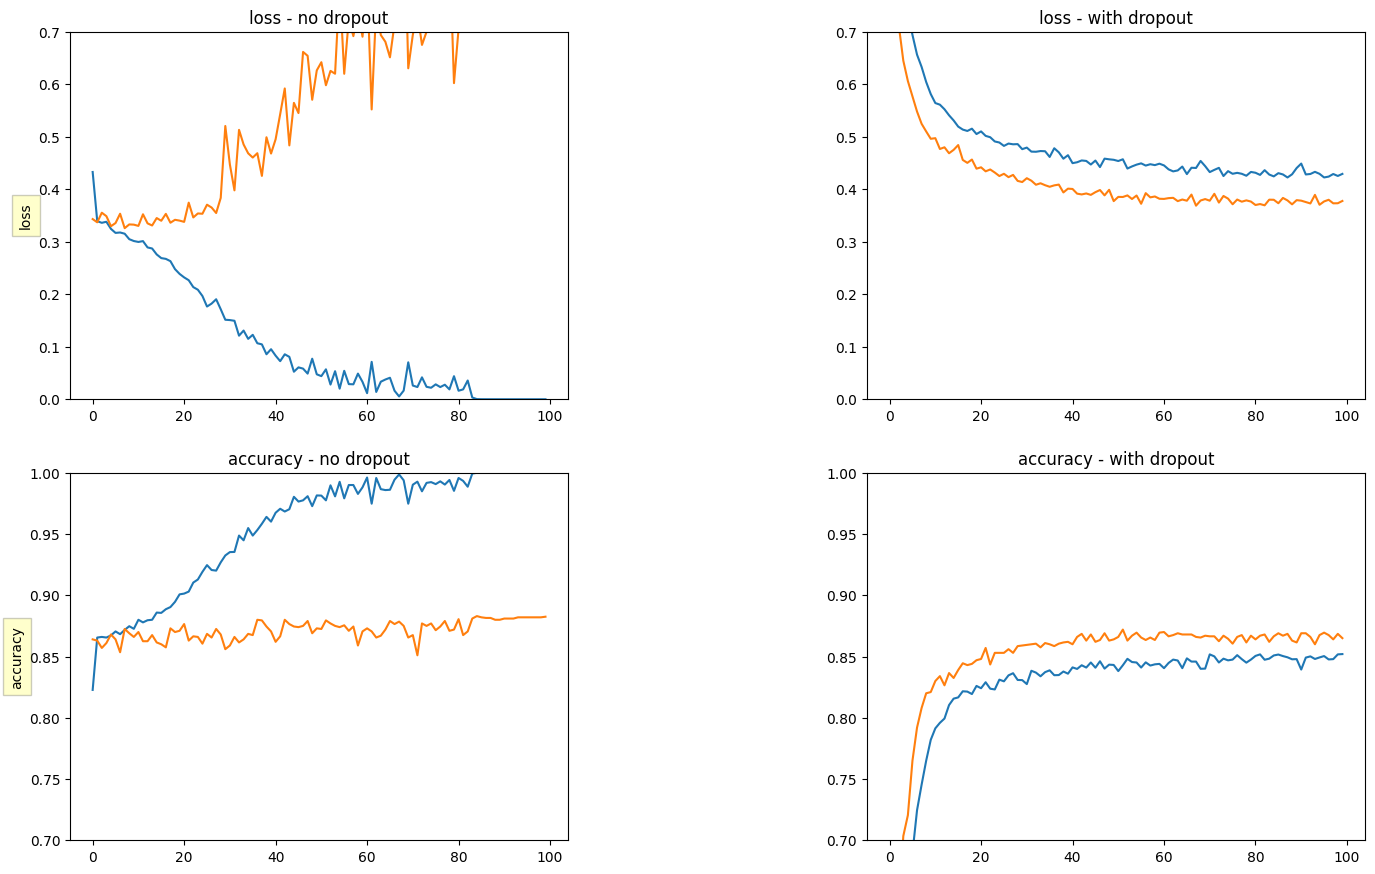

In [39]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, history_0, history_2)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

What is the interpretation? (The example is surely very artificial.)

[Return to Top](#returnToTop)  
<a id = 'normalization'></a>

## 6. Effect of Layer Normalization

In the last step, let's quickly introduce the **Functional API** and then specifically look at the effect of Layer Normalization.  The functional API lets us define each of our layers separately and then connect them together as we see fit.  We no longer have to wrap our layers as a sequence.  We can create arbitrarily complex architectures which we will see in later classes.  Here we will want two separate outputs.  The first output will be what comes out of our dense layer.  The second will be what happens after we pass that dense layer output through a normalization layer.  The functional API lets us look at both of these rather than just the output at the end of the sequence.

In [40]:
try:
    del function_model_layer_norm
except:
    pass

# Functional API!
# Define inputs, then network architecture build as a series of:
#     layer_output = layer(earlier_layer_output)
# then define model through input list and output list

inputs = layers.Input(shape=(20,))

dense_layer =  layers.Dense(5, activation='relu',
                              kernel_initializer=keras.initializers.glorot_normal,
                              name='layer_1')

dense_out = dense_layer(inputs)

# now add layer normalization layer
final_out = layers.LayerNormalization()(dense_out)

# use actual 2 layers as model outputs to see the effect of the layer normalization.
# Note that the model outputs includes dense_out AND final_out
function_model_layer_norm = keras.models.Model(inputs=[inputs], outputs=[dense_out, final_out])

Let's look at the effect of normalization.  First the output from the dense layer.

In [41]:
pred_layer_after_dense, pred_layer_after_norm = function_model_layer_norm.predict(data[:2], batch_size=2)
pred_layer_after_dense

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(2, 20))
  warnings.warn(msg)


array([[0.1865682 , 0.        , 0.        , 0.        , 0.        ],
       [0.04400593, 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

Now lets see the output after it has passed through the normalization layer.

In [42]:
pred_layer_after_norm

array([[ 1.841494  , -0.4603735 , -0.4603735 , -0.4603735 , -0.4603735 ],
       [ 0.97272813, -0.24318205, -0.24318205, -0.24318205, -0.24318205]],
      dtype=float32)

Let's look at the sum and standard deviations of the normalized output:

In [43]:
np.sum(pred_layer_after_norm, axis=-1)

array([-5.9604645e-08, -8.9406967e-08], dtype=float32)

In [44]:
np.std(pred_layer_after_norm, axis=-1)

array([0.9207469 , 0.48636404], dtype=float32)

Looks reasonable?